In [7]:
# specify id
y_id = 0
track_id = 2
server = 4

In [8]:
# import module
import sys
sys.path.insert(0, '../')
from utils.training_utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# load datas
test_x, train_x, train_y = load_data(y_id)
print(test_x.shape, train_x.shape, train_y.shape)

(2500, 10000) (47500, 10000) (47500,)


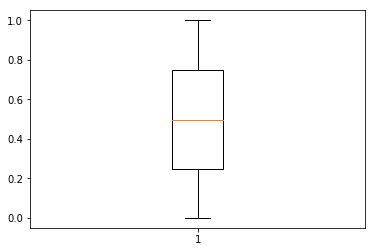

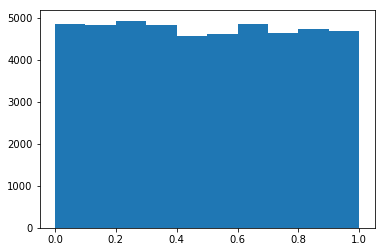

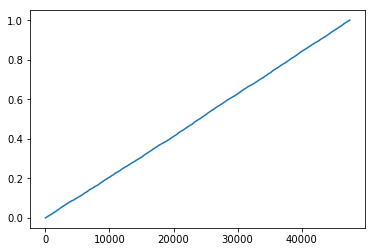

[0.13075429 0.99203844 0.89332137 ... 0.10934975 0.96231866 0.03180611]


,0
count,47500.000000
mean,0.496567
std,0.289391
min,0.000072
25%,0.245903
50%,0.494967
75%,0.747978
max,0.999971


In [10]:
# draw distribution of y0
plt.boxplot(train_y)
plt.show()
plt.hist(train_y)
plt.show()
x = sorted(train_y)
plt.plot(x)
plt.show()
print(train_y)
d = pd.DataFrame(train_y)
d.describe()

In [12]:
# pick only important data
idx = {}
with open('../29/adaboost' + str(y_id) + '_feature.csv', 'r') as f:
    i = 0
    for lines in f:
        importance = float(lines.replace('\n', '').split(',')[y_id])
        if i not in idx:
            idx[i] = 0
        idx[i] += importance
        i += 1
with open('../28/adaboost' + str(y_id) + '_feature.csv', 'r') as f:
    i = 0
    for lines in f:
        importance = float(lines.replace('\n', '').split(',')[y_id])
        if i not in idx:
            idx[i] = 0
        idx[i] += importance
        i += 1

with open('../32/adaboost' + str(y_id) + '_feature.csv', 'r') as f:
    i = 0
    for lines in f:
        importance = float(lines.replace('\n', '').split(',')[y_id])
        if i not in idx:
            idx[i] = 0
        idx[i] += importance
        i += 1
with open('../35/random_forest' + str(y_id) + '_feature.csv', 'r') as f:
    i = 0
    for lines in f:
        importance = float(lines.replace('\n', '').split(',')[y_id])
        if i not in idx:
            idx[i] = 0
        idx[i] += importance
        i += 1
    
idxx = [i[0] for i in idx.items() if i[1] > 1e-3]
print(len(idxx))
train_x = train_x[:, idxx]
test_x = test_x[:, idxx]
print(train_x.shape)

157
(47500, 157)


In [13]:
cnt = 0
for i in train_y:
    v = 1 / i // 10 + 1
    cnt += v
print(cnt)

scaled_x = []
scaled_y = []
for i, j in zip(train_x, train_y):
    v = int(1 / j // 10 + 1)
    for _ in range(v):
        scaled_x.append(i)
        scaled_y.append(j)
scaled_x = np.array(scaled_x)
scaled_y = np.array(scaled_y)
print(scaled_x.shape)

82334.0
(82334, 157)


In [14]:
# define my own scorer
def scorer(y, y_pred):
    return -np.sum(np.abs(y - y_pred) / y) / len(y)

In [15]:
# define my own error function
def mae(y_true, y_pred):
    grad = np.tanh(y_pred - y_true)
    hess = 1 - grad * grad
    return grad, hess

In [16]:
# specify parameters
params_xgbr = {
    'objective': mae
}
params_cv = {
    'max_depth': [6],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [100, 500, 1000],
    'verbosity': [2],
    'booster': ['gbtree', 'dart'],
    'n_jobs': [8],
    'subsample': [0.5, 0.75]
}

In [17]:
# create XGBRegressor
model = GridSearchCV(estimator=XGBRegressor(**params_xgbr),
                     param_grid=params_cv, 
                     scoring=make_scorer(scorer),
                     cv=3,
                     verbose=20,
                     n_jobs=4,
                     return_train_score=True)
model.fit(train_x, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   40.6s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   41.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  6.5min
[Parallel(

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective=<function mae at 0x7fa2799c8598>,
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [6], 'learning_rate': [0.1, 0.5, 1], 'n_estimators': [100, 500, 1000], 'verbosity': [2], 'booster': ['gbtree', 'dart'], 'n_jobs': [8], 'subsample': [0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(scorer), verbose=20)

In [18]:
print("err2:", err2_calc(model.predict(train_x), train_y))
print("err1:", err1_calc(model.predict(train_x), train_y, y_id))
print("params:", model.best_params_)
print("best scores:", model.best_score_)

err2: 0.23786365094575657
err1: 8.153508027431808
params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000, 'n_jobs': 8, 'subsample': 0.75, 'verbosity': 2}
best scores: -0.6156320996320521


In [25]:
print("YA")

YA


In [20]:
# create XGBRegressor
model2 = GridSearchCV(estimator=XGBRegressor(**params_xgbr),
                     param_grid=params_cv, 
                     scoring=make_scorer(scorer),
                     cv=3,
                     verbose=20,
                     n_jobs=4,
                     return_train_score=True)
model2.fit(scaled_x, scaled_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   52.6s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   53.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  8.9min
[Parallel(

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective=<function mae at 0x7fa2799c8598>,
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [6], 'learning_rate': [0.1, 0.5, 1], 'n_estimators': [100, 500, 1000], 'verbosity': [2], 'booster': ['gbtree', 'dart'], 'n_jobs': [8], 'subsample': [0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(scorer), verbose=20)

In [21]:
print("err2:", err2_calc(model2.predict(train_x), train_y))
print("err1:", err1_calc(model2.predict(train_x), train_y, y_id))
print("params:", model2.best_params_)
print("best scores:", model2.best_score_)

err2: 0.30638632876714406
err1: 17.47439003239659
params: {'booster': 'dart', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'n_jobs': 8, 'subsample': 0.75, 'verbosity': 2}
best scores: -11.948946088959358


In [23]:
# write files
write_prediction('train_y' + str(y_id) + '_' + str(track_id) + 'depth=6.txt', 'w', model2.predict(train_x).reshape((47500, 1)).astype('str'))
write_prediction('test_y' + str(y_id) + '_' + str(track_id) + 'depth=6.txt', 'w', model2.predict(test_x).reshape((2500, 1)).astype('str'))

In [26]:
x = model2.best_estimator_
x.save_model('y0_2_depth=6.model')